In [ ]:
!pip install shap

In [ ]:
import pandas as pd
import shap
import openai
import numpy as np
from dotenv import load_dotenv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
env_path = '/content/drive/MyDrive/Personalized-Narratives/.env'
load_dotenv(dotenv_path=env_path)

api_key = os.getenv("UNI_API_KEY")


In [ ]:
class SHAPstory:
    """
    Generate narrative explanations (SHAPstories) using SHAP values and LLMs (e.g., GPT-4).
    """

    def __init__(self, api_key, feature_desc_df, dataset_description,
                 input_description, target_description, gpt_model="gpt-4"):
        self.api_key = api_key
        self.feature_desc_df = feature_desc_df
        self.dataset_description = dataset_description
        self.input_description = input_description
        self.target_description = target_description
        self.gpt_model = gpt_model

    def gen_shap_feature_df(self, x, model, tree=True):
        explainer = shap.TreeExplainer(model) if tree else shap.KernelExplainer(model.predict, x)
        shap_vals = explainer(x)
        df = x.copy()
        self.values_df = x.copy()
        self.shap_df = pd.DataFrame(shap_vals.values, columns=df.columns)
        #print(shap_vals)

        for i, col in enumerate(df.columns):
            df[f"{col} SHAP Value"] = shap_vals.values[:, i] #Adds a new column per feature like "Age SHAP Value" to the copied dataframe
        #print(df.head())
        return df

    def gen_variables(self, model, x, y, tree=True):
        self.shap_feature_df = self.gen_shap_feature_df(x, model, tree)
        y_pred = model.predict(x)
        y_scores = model.predict_proba(x)[:, 1]
        self.result_df = pd.DataFrame({"truth": y, "pred": y_pred, "score": y_scores})
        #df_filtered = self.result_df[self.result_df["truth"] != self.result_df["pred"]]
        #print(df_filtered.head())

    def generate_prompt(self, iloc_pos, audience,sentence_limit=10,num_feat=3,prompt_type='long',use_education=False):
        #print(self.result_df.iloc[iloc_pos])

        row = self.result_df.iloc[iloc_pos]
        ground_truth = row["truth"]
        prediction = row["pred"]
        score = row["score"]

        #print (ground_truth, prediction, score)
        #print(self.result_df)

        if prediction:
          result_string = "The model predicted that the applicant's loan application was approved."
        else:
          result_string = "The model predicted that the applicant's loan application was denied."

        # Audience-specific instruction
        if audience == 'layperson':
            personalization = "Ensure the explanation is easy to understand for someone without a financial or technical background. \
            Use everyday language, metaphors if helpful, and concrete examples. Do not mention SHAP values, model internals, or technical terms.\
            Use simple language that a high school student could easily understand.\
            Avoid all technical or financial jargon. Use short sentences and clear structure. Prefer plain explanations over precision.\
            Think like a helpful advisor drafting a credit acceptance or rejection letter to someone with no background in credit or statistics."
        elif audience == 'credit_officer':
            personalization = "Explain the prediction like it is a report to a professional credit analyst. Use formal financial language.\
             Include references to key risk indicators and their feature values that reflect creditworthiness assessment."
        elif audience == 'general':
            personalization = "Provide a balanced explanation suitable for a general audience."


        if use_education:
          # Optional demographics injection
          education_levels_instructions = {
              "High School": "The applicant has completed high school. Use plain, everyday language, keep sentences short, and avoid all technical or financial jargon. Avoid statistics unless extremely simple. Use relatable examples when possible.",
              "Associate": "The applicant has completed an associate degree. Use simple, clear sentences with limited technical terms. Provide brief explanations for any financial terms and avoid unnecessary complexity.",
              "Bachelor": "The applicant holds a bachelor's degree. Use moderately formal language, allow some technical terms, but define them briefly.Maintain a logical flow and concise explanations, offering slightly more detail than for lower education levels.",
              "Master": "The applicant holds a master's degree. Use clear, precise, and well-structured language, and feel free to explore more nuanced reasoning. You may introduce moderately complex concepts, but always explain any financial or domain-specific terms, as the degree may be in an unrelated field. Keep the tone formal yet accessible.",
              "Doctorate": "The applicant holds a doctoral degree. Use a formal and articulate style with complex sentence structures where appropriate. Provide in-depth reasoning and connections between factors, but do not assume prior financial expertise—define any technical terms and avoid unnecessary jargon.Emphasize logical clarity and depth over terminology density."
          }


          education_columns = [
              'EducationLevel_Bachelor',
              'EducationLevel_Doctorate',
              'EducationLevel_High School',
              'EducationLevel_Master',
              'EducationLevel_Associate'
          ]


          education_df = self.values_df.iloc[iloc_pos][education_columns]

          edu_level = education_df[education_df == 1].index[0] if 1 in education_df.values else None
          if edu_level:
            edu_level = edu_level.replace("EducationLevel_", "")
          else:
            edu_level = "Not found"
          print(edu_level)

          education_instruction = education_levels_instructions.get(edu_level, "")





        # Format SHAP table and feature descriptions
        shap_table = self.shap_feature_df.iloc[iloc_pos].to_string()
        feature_info = pd.DataFrame(self.feature_desc_df, columns=['Description']).to_string(index=False)


        feature_info_df = pd.DataFrame({
            'feature_name': self.shap_df.columns,
            'Description': self.feature_desc_df,
            'feature_value': self.values_df.iloc[iloc_pos].values,
            #'Average Value': X_data.mean().values,
            'SHAP Value': self.shap_df.iloc[iloc_pos].values
        })

        #print(feature_info_df)

        long_prompt=f"""

    Your goal is to generate a textual explanation or narrative as to why an AI model made a certain prediction for one particular instance.
    To do this, you will be provided with a dictionary that contains broad descriptions of the specific dataset, target variable, and the task the model was trained on.
    Additionally, you will be provided with a dataframe that contains the names of all the features, their descriptions, their values and their SHAP values.
    Finally you will get a single string describing the result of the prediction.

    The goal of SHAP is to explain the prediction of an instance by computing the contribution of each feature to the prediction.
    Each individual SHAP value is a measure of how much additional probability this feature adds or subtracts
    in the predicted probability relative to the base level probability.
    This relative nature of the SHAP values might have unexpected consequences that you are to take into account.
    For example, features that should intuitively contribute in a positive way (and vice versa),
    can still have negative SHAP values if their value is below an average in the dataset.

    Here is the data:

    Dataset description: {self.dataset_description[0]},
    Target description: {self.target_description},
    Input description: {self.input_description[0]},
    Feature table: {feature_info_df.sort_values(by='SHAP Value', key=abs, ascending=False)},
    Result: {result_string}

    The features in the "Feature table" above are already sorted by their absolute SHAP values to make it easier for you to locate the most important ones.

    Please generate a fluent and cohesive narrative that explains the prediction made by the model. In your answer follow these rules.

    Format related rules:

    1) You can start the answer immediately with the explanation.
    2) The answer should end with a single sentence summarizing and weighing the different factors.
    3) Limit the entire answer to {sentence_limit} sentences or fewer.
    4) Only invoke the {num_feat} most important features in the narrative.
    5) Do not use tables or lists, or simply rattle through the features one by one. The goal is to have a narrative/story.

    Content related rules:

    1) Be clear about what the model actually predicted and how certain it was about that prediction.
    2) Discuss how the features contributed to that prediction and be clear about whether a particular feature had a positive or negative contribution. Make sure to clearly establish this the first time you refer to a feature.
    3) Consider the relative magnitude of the absolute SHAP values of the {num_feat} features when referencing their relative importance. Only invoke the {num_feat} features with the highest absolute SHAP value in the narrative.
    4) The reader should be able to tell what the order of importance of the features is based on their absolute SHAP values.
    5) You should provide a suggestion or interpretation as to why a feature contributed in a certain direction. Try to introduce external knowledge that you might have that is not in the SHAP table.
    6) If there is no simple explanation for the effect of a feature, try to consider the context of other features in the interpretation.
    7) Do not use the SHAP numeric values in your answer.
    8) You can use the feature values themselves in the explanation, as long as they are not categorical variables.


    {("This is very important: The story should also be adapted to the applicant's education level. " + education_instruction)
    if use_education
    else
    "Note: You should tailor the story to a specific audience type, according to the following instructions. "
     + personalization}

    """
        # Short prompt
        prompt = f"""An AI model was used to predict {self.dataset_description}.
    The input features of the data include data about {self.input_description}.
    The target variable is a label stating the probability that {self.target_description}.

    A certain instance in the test dataset was {'correctly classified' if prediction == ground_truth else 'misclassified'}.
    The AI model predicted a {score:.2%} probability ('{prediction}') that {self.target_description}.
    The actual outcome was {ground_truth}. The provided SHAP table was generated to explain this
    outcome. It includes every feature along with its value for that instance, and the
    SHAP value assigned to it.

    The goal of SHAP is to explain the prediction of an instance by
    computing the contribution of each feature to the prediction. The
    SHAP explanation method computes Shapley values from coalitional game
    theory. The feature values of a data instance act as players in a coalition.
    Shapley values tell us how to fairly distribute the “payout” (= the prediction)
    among the features. A player can be an individual feature value, e.g. for tabular
    data. The scores in the table are sorted from most positive to most negative.

    Can you come up with a plausible, fluent story as to why the model could have
    predicted this outcome, based on the most influential positive and most influential
    negative SHAP values? Focus on the features with the highest absolute
    SHAP values. Try to explain the most important feature values in this story, as
    well as potential interactions that fit the story. No need to enumerate individual
    features outside of the story. Conclude with a short summary of why this
    classification may have occurred. Limit your answer to 8 sentences.

    SHAP table:
    {shap_table}

    Feature descriptions:
    {feature_info}

    Note: The story should be tailored to the following audience type.
    {personalization}
    """
        #print(prompt)
        if prompt_type == 'short':
            return prompt,feature_info_df
        return long_prompt,feature_info_df


    def generate_response(self, prompt, temp=0.2):
        #return 0
        client = openai.OpenAI(api_key=self.api_key)
        response = client.chat.completions.create(
          model=self.gpt_model,
          messages=[{"role": "user", "content": prompt}],
          temperature=temp,
          max_tokens=1000
          )
        return response.choices[0].message.content

    def generate_stories(self, model, x, y, audience='general', temp=0.2, use_education = False, tree=True):
        self.gen_variables(model, x, y, tree)
        result = []
        for i in range(len(x)):
          row = []
          prompt, feature_info_df = self.generate_prompt(i, audience, use_education = use_education)
          #print(prompt)
          print(i)
          print('-'*5)
          row.append(self.generate_response(prompt, temp))
          row.append(feature_info_df)

          result.append(row)
        return result

        #return [self.generate_response(self.generate_prompt(i, audience), temp) for i in range(len(x))]#list comprehension

In [ ]:
import joblib
import pandas as pd
import numpy as np

# Load model
xgb_model = joblib.load("/content/drive/MyDrive/exports/xgb_model_final.pkl")

# Load test data
X_test_processed = pd.read_csv("/content/drive/MyDrive/exports/X_test_processed_final.csv")
y_test = pd.read_csv("/content/drive/MyDrive/exports/y_test_final.csv").squeeze()  # .squeeze() to get a Series



In [ ]:
feature_desc_df = [
'Age: Age of the applicant',
'AnnualIncome: Yearly income of the applicant',
'LoanAmount: Loan amount requested',
'LoanDuration: Duration of the loan in months',
'NumberOfDependents: Number of dependents of the applicant',
'MonthlyDebtPayments: Monthly debt obligations of the applicant',
'CreditCardUtilizationRate: Credit card usage percentage',
'NumberOfOpenCreditLines: Number of the active credit lines of the applicant',
'NumberOfCreditInquiries: Number of credit checks made',
'DebtToIncomeRatio: Debt-to-income ratio for the applicant',
'BankruptcyHistory: Indicates if the applicant has a bankruptcy record (1 for true, 0 for false)',
'PreviousLoanDefaults: Indicates if the applicant has prior loan defaults (1 for true, 0 for false)',
'PaymentHistory: Past payment behavior of the applicant',
'LengthOfCreditHistory: Credit history duration in months',
'SavingsAccountBalance: Savings account amount of the applicant',
'CheckingAccountBalance: Checking account funds of the applicant',
'TotalLiabilities: Total owed debts of the applicant',
'UtilityBillsPaymentHistory: Utility payment record',
'JobTenure: Job duration',
'NetWorth: Total financial worth of the applicant',
'InterestRate: Applied interest rate',
'EmploymentStatus_Self-Employed: Indicates if the applicant\'s employment status is Self-Employed (1 for true, 0 for false)',
'EmploymentStatus_Unemployed: Indicates if the applicant\'s employment status is Unemployed (1 for true, 0 for false)',
'EducationLevel_Associate: Indicates if the applicant\'s highest education level is an Associate degree(1 for true, 0 for false)',
'EducationLevel_Bachelor: Indicates if the applicant\'s highest education level is a Bachelor\'s degree (1 for true, 0 for false)',
'EducationLevel_Doctorate: Indicates if the applicant\'s highest education level is a Doctorate degree (1 for true, 0 for false)',
'EducationLevel_High School: Indicates if the applicant\'s highest education level is High School (1 for true, 0 for false)',
'EducationLevel_Master: Indicates if the applicant\'s highest education level is a Master\'s degree (1 for true, 0 for false)',
'MaritalStatus_Divorced: Indicates if the applicant\'s marital status is Divorced (1 for true, 0 for false)',
'MaritalStatus_Married: Indicates if the applicant\'s marital status is Married (1 for true, 0 for false)',
'MaritalStatus_Widowed: Indicates if the applicant\'s marital status is Widowed (1 for true, 0 for false)',
'HomeOwnershipStatus_Other: Indicates if the applicant\'s home ownership status is Other (1 for true, 0 for false)',
'HomeOwnershipStatus_Own: Indicates if the applicant owns their home (1 for true, 0 for false)',
'HomeOwnershipStatus_Rent: Indicates if the applicant rents their home (1 for true, 0 for false)',
'LoanPurpose_Auto: Indicates if the loan purpose is auto (1 for true, 0 for false)',
'LoanPurpose_Debt Consolidation: Indicates if the loan purpose is Debt Consolidation (1 for true, 0 for false)',
'LoanPurpose_Education: Indicates if the loan purpose is Education (1 for true, 0 for false)',
'LoanPurpose_Home: Indicates if the loan purpose is for Home-related expenses (1 for true, 0 for false)',
'LoanPurpose_Other: Indicates if the loan purpose is Other (1 for true, 0 for false)'
]


--- Generating SHAP Explanation for a Single Instance ---
.values =
array([[ 3.0182466e-01,  2.6985569e+00,  2.9660492e+00, -8.3493865e-01,
         2.7105546e-01,  6.6912331e-02, -1.7330205e-01,  1.1542966e-02,
        -1.4518706e-02, -3.2830931e-02,  1.2174593e-01,  1.8792729e-01,
        -2.5602475e-01,  1.9462280e-02,  2.1143295e-01, -2.2638854e-01,
         8.2343400e-02,  8.1122138e-02, -2.1406274e-02, -8.1005687e-01,
        -1.9130121e+00, -7.4261799e-04,  9.3288191e-02,  2.6493004e-02,
        -1.0195515e-02, -8.3805755e-02, -7.7283508e-01, -2.0084304e-01,
        -1.7514736e-03, -5.8492858e-02,  1.2985007e-02, -3.8064292e-01,
        -7.0608882e-03,  3.0507721e-02, -1.2892315e-03,  1.9049530e-03,
        -1.5580364e-02,  4.9123410e-02, -1.6988030e-02]], dtype=float32)

.base_values =
array([-1.4239979], dtype=float32)

.data =
array([[4.50000000e+01, 9.50600000e+04, 5.49900000e+03, 9.60000000e+01,
        0.00000000e+00, 3.37000000e+02, 5.17402747e-01, 3.00000000e+00,
      

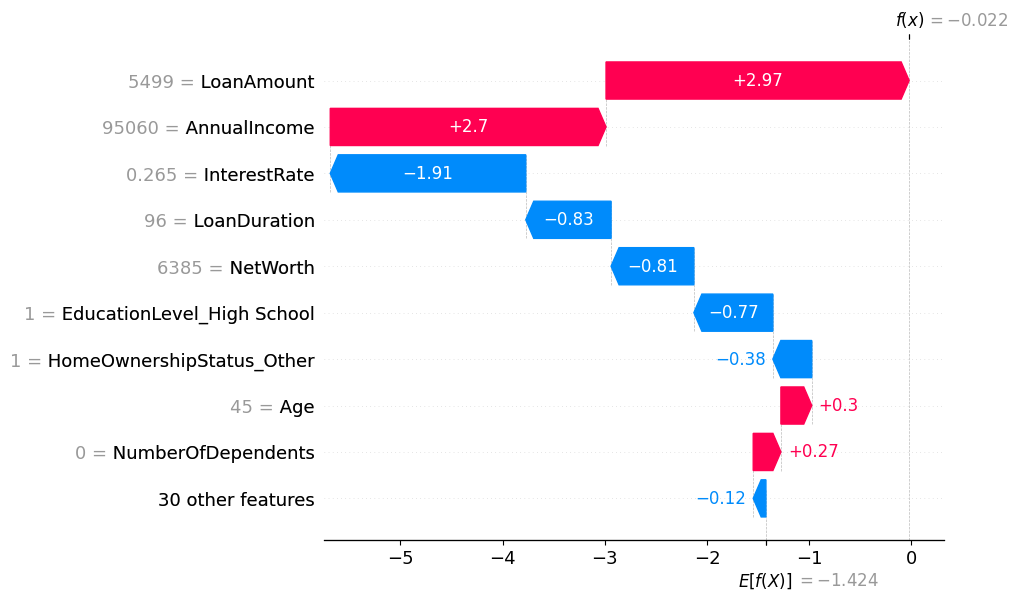

In [ ]:
print("\n--- Generating SHAP Explanation for a Single Instance ---")

# Select the first instance
instance = X_test_processed.iloc[[1]]

# Instantiate the explainer
explainer = shap.TreeExplainer(xgb_model)


# Get SHAP values
shap_values = explainer(instance)
print(shap_values)

print("SHAP values calculated for the first instance.")
print(f"Expected value (base value): {shap_values.base_values[0]:.4f}")

shap.initjs()

# Waterfall plot
shap.plots.waterfall(shap.Explanation(values=shap_values.values[0], base_values=shap_values.base_values[0], data=shap_values.data[0], feature_names=shap_values.feature_names))


In [ ]:
def create_feature_summary_df(instance_index, X_data, feature_descriptions, model, explainer):
    """
    Creates a DataFrame summarizing feature information for a given instance.

    Args:
        instance_index (int): The index of the instance in X_data.
        X_data (pd.DataFrame): The DataFrame containing the feature data.
        feature_descriptions (list): A list of feature descriptions aligned with X_data columns.
        model: The trained model used for predictions.
        explainer: The SHAP explainer object.

    Returns:
        pd.DataFrame: A DataFrame with feature name, description, value,
                      average value, and SHAP value for the specified instance.
    """
    instance_data = X_data.iloc[instance_index]
    shap_values_instance = explainer(X_data.iloc[[instance_index]])

    feature_info_df = pd.DataFrame({
        'Feature Name': X_data.columns,
        'Description': feature_descriptions,
        'Value': instance_data.values,
        'Average Value': X_data.mean().values,
        'SHAP Value': shap_values_instance.values[0]
    })

    return feature_info_df

# summary_df = create_feature_summary_df(instance_index_to_summarize, X_test_processed, feature_desc_df, xgb_model, explainer)
summary_df = create_feature_summary_df(1, X_test_processed, feature_desc_df, xgb_model, explainer)

display(summary_df.head())

,Feature Name,Description,Value,Average Value,SHAP Value
0,Age,Age: Age of the applicant,0.435484,0.352246,0.382951
1,AnnualIncome,AnnualIncome: Yearly income of the applicant,0.170217,0.092501,1.412951
2,CreditScore,CreditScore: Creditworthiness score of the app...,0.596206,0.619738,0.040843
3,LoanAmount,LoanAmount: Loan amount requested,0.010080,0.116712,0.719521
4,LoanDuration,LoanDuration: Duration of the loan in months,0.777778,0.390306,-0.812046


In [ ]:
dataset_description="whether an applicant is likely to be approved or denied for a loan, based on a collection of personal and financial data.",
input_description= "diverse features such as demographic information, credit history, employment status, income levels, existing debt, and other relevant financial metrics for each applicant",
target_description="whether the applicant is likely to be approved or denied for a loan"

shap_story_instance = SHAPstory(
    api_key=api_key,
    feature_desc_df= feature_desc_df,
    dataset_description=dataset_description,
    input_description= input_description,
    target_description=target_description
)

audience_type = 'credit_officer'

stories = shap_story_instance.generate_stories(xgb_model, X_test_processed.iloc[0:30], y_test.iloc[0:30], audience = audience_type, temp=0.2, use_education = False, tree=True)

0
-----
1
-----
2
-----
3
-----
4
-----
5
-----
6
-----
7
-----
8
-----
9
-----
10
-----
11
-----
12
-----
13
-----
14
-----
15
-----
16
-----
17
-----
18
-----
19
-----
20
-----
21
-----
22
-----
23
-----
24
-----
25
-----
26
-----
27
-----
28
-----
29
-----


In [ ]:
len(stories)

30

In [ ]:
education_columns = [
            'EducationLevel_Bachelor',
            'EducationLevel_Doctorate',
            'EducationLevel_High School',
            'EducationLevel_Master',
            'EducationLevel_Associate'
        ]
education_level = []
for story in stories:
  #print(story[1])
  education_df = story[1][story[1]['feature_name'].isin(education_columns)]

  edu_level = education_df[education_df['feature_value'] == 1]['feature_name'].values[0]

  if edu_level:
    edu_level = edu_level.replace("EducationLevel_", "")
  else:
    edu_level = "Not found"
  education_level.append(edu_level)
  print(edu_level)


  #break


Associate
High School
Bachelor
Bachelor
Doctorate
Bachelor
Bachelor
Doctorate
Bachelor
Bachelor
Bachelor
Bachelor
Associate
High School
High School
Associate
High School
Master
High School
High School
High School
Associate
Bachelor
Bachelor
Bachelor
Bachelor
Bachelor
Associate
Bachelor
Bachelor


In [ ]:
'''
####This cell should be used only when use_education = True
narratives = [item[0] for item in stories]

# Convert the list of stories to a pandas DataFrame
stories_df = pd.DataFrame({"story":narratives,
                           "education": education_level})

# Save the DataFrame to an Excel file
stories_df.to_excel(f'/content/drive/My Drive/Colab Notebooks/{audience_type}_stories_education.xlsx', index=False)
'''

In [ ]:
dfs_dict = {}
i=0
for item in stories:
  dfs_dict[str(i)] = item[1]
  i+=1


In [ ]:
!pip install xlsxwriter

In [ ]:
with pd.ExcelWriter(f'/content/drive/My Drive/Colab Notebooks/{audience_type}_initial_shap_values_final.xlsx', engine='xlsxwriter') as writer:
    for sheet_name, df in dfs_dict.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

In [ ]:
narratives = [item[0] for item in stories]

# Convert the list of stories to a pandas DataFrame
stories_df = pd.DataFrame(narratives, columns=['Story'])

# Save the DataFrame to an Excel file
stories_df.to_excel(f'/content/drive/My Drive/Colab Notebooks/{audience_type}_stories_final.xlsx', index=False)

In [ ]:
narratives[0]

"The AI model predicted that the loan application would be denied. The primary factors contributing to this decision were the applicant's total debt to income ratio, annual income, and previous loan defaults. \n\nThe total debt to income ratio was the most significant factor. This ratio is a measure of an individual's ability to manage monthly payment obligations. A high ratio indicates that the applicant may have trouble making payments, which increases the risk for the lender. \n\nThe second most influential factor was the applicant's annual income. A lower income can make it more challenging to handle loan repayments, which could have led the model to predict a higher risk of default. \n\nLastly, the applicant's history of previous loan defaults also played a significant role in the decision. Past behavior is often a good predictor of future actions, and a history of defaults suggests a higher likelihood of future defaults. \n\nIn summary, the model's prediction was based on a combi

In [ ]:
#stories = shap_story_instance.generate_stories(xgb_model, X_test_processed.iloc[:2], y_test.iloc[:2], audience='layman', temp=0.2, tree=True)

In [ ]:
#stories[0]

In [ ]:
X_test_processed.iloc[0].sort_values(ascending=False)

,0
LoanPurpose_Education,1.000000
MaritalStatus_Married,1.000000
PreviousLoanDefaults,1.000000
CreditScore,0.720867
UtilityBillsPaymentHistory,0.445676
JobTenure,0.437500
DebtToIncomeRatio,0.427249
InterestRate,0.371987
Age,0.338710
LoanDuration,0.333333


In [ ]:
pd.set_option('display.max_columns', None)